<a href="https://colab.research.google.com/github/al025/Machine-Learning-Study-Notes/blob/master/c2_chap3_decorelate_data_dim_red.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Application
- cluster Wikipedia articles by their contents 

### Objectives
- use PCA to decorrelate features 
- use PCA to reduce dimensions
- use TfidfVectorizer to vectorize text 
- use TruncatedSVD to reduce dimensions of a sparse matrix (a cst_matrix object)

### Data
- Grains 
- Wikipedia articles


In [5]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/My Drive/MachineLearningDatacampCareerTrack/c2_sklearn_unsupervised/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Demo 1: PCA decorrelate features 
- PCA shift data samples to be centred at the origin (to have mean 0) and align data samples with axes (principal components are the new basis)
- no info is lost in this fitting process 
- by doing so, PCA decorrelate features (PCA features are orthogonal)
- PCA.components_ is a ndarray (the new basis), in descending order of l2 norm (variance) 
- higher variance $\rightarrow$ this feature serves our purpose (classification, regression) better
- Pearson correlation score $\in [-1,1]$, measures *linear* correlation
  - closer to 1 $\rightarrow$ more positively correlated
  - closer to -1 $\rightarrow$ more negatively correlated
  - close to 0 $\rightarrow$ not correlated

(209, 2)
<class 'pandas.core.frame.DataFrame'>


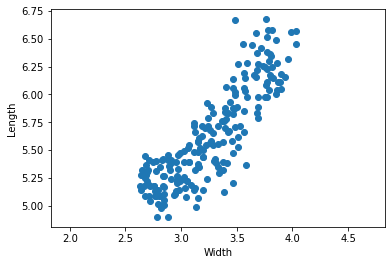

0.8604405325922296


In [6]:
# load dataset
import pandas as pd
fname = dir + '/Grains/seeds-width-vs-length.csv'
grains = pd.read_csv(fname) 
print(grains.shape)
print(type(grains))
# visualize the data space and print correlation score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

width, length = grains.iloc[:,0], grains.iloc[:,1]
plt.scatter(width, length)
plt.xlabel('Width')
plt.ylabel('Length')
plt.axis('equal')
plt.show()

correlation, pvalue = pearsonr(width, length)
print(correlation)

(209, 2)
<class 'numpy.ndarray'>


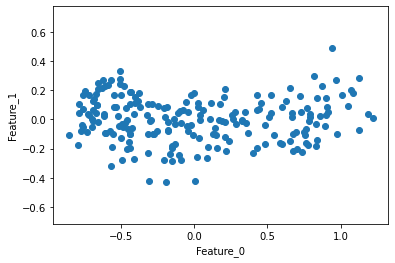

-2.413434035952733e-16


In [13]:
# visualize the PCA-transformed data space and print the correlation score
from sklearn.decomposition import PCA
pca = PCA()
features = pca.fit_transform(grains)
print(features.shape)
print(type(features))
xs, ys = features[:,0], features[:,1]
plt.scatter(xs, ys)
plt.xlabel('Feature_0')
plt.ylabel('Feature_1')
plt.axis('equal')
plt.show()

correlation, pvalue = pearsonr(xs, ys)
print(correlation)

Demo 2: understand what are **principal components** and **intrinsic dimension**
- principal components = directions of variance
- PCA aligns principal components with axes 
- principal components essentially change basis of the data points




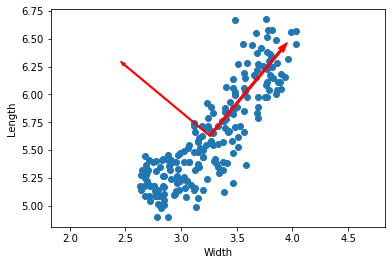

In [12]:
plt.scatter(width, length)
plt.xlabel('Width')
plt.ylabel('Length')
plt.axis('equal')
mean = pca.mean_
component_1 = pca.components_[0]
plt.arrow(mean[0], mean[1], component_1[0], component_1[1], color='red', width=0.02)
component_2 = pca.components_[1]
plt.arrow(mean[0], mean[1], component_2[0], component_2[1], color='red', width=0.01)
plt.show()

demo 3: understand what are **intrinsic dimension**
- instrinsic dimension = number of dimensions needed to approximate the dataset
- instrinsic dimension shows how compact the dataset can be represented
- analogy: view individual features as small Lego pieces, then principal components are like parts assembled from pieces, more conveniently used to build towards our goal

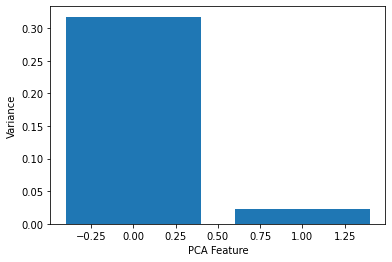

In [14]:
features = range(len(pca.components_))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.show()
# we can see that width, length can be represented by 1 pc; i.e. instrinsic dim=1
# this is why we can do dimension reduction with PCA

Demo 4: use PCA to reduce dimensions

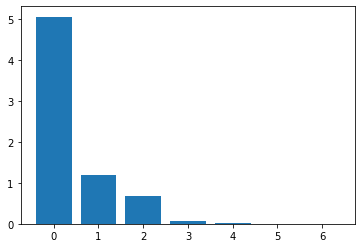

(209, 3)


In [26]:
# load data 
fname = dir + '/Grains/seeds.csv'
df = pd.read_csv(fname) # 209 samples, 7 feature variables, 1 target variable
samples = df.iloc[:,:7] 

# fit and transform samples in R^7 to R^3
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA()
pipeline = make_pipeline(StandardScaler(), pca)
pipeline.fit(samples)
# we can peek at the intrinsic dimension
plt.bar(range(len(pca.components_)), pca.explained_variance_)
plt.show()
# the first 3 components have high variance
pca = PCA(n_components=3)
pipeline = make_pipeline(StandardScaler(), pca)
pca_features = pipeline.fit_transform(samples)
print(pca_features.shape)


Demo 5: Use TfidfVectorizer to convert text dataset to word frequency array


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# toy dataset
documents = ['You would have searched a long time', 'for the sort of winding lane', 'for which England later became celebrated']

tfidf = TfidfVectorizer()
csr_mat = tfidf.fit_transform(documents)
print(csr_mat.toarray())

words = tfidf.get_feature_names()
print(words)

[[0.         0.         0.         0.         0.40824829 0.
  0.         0.40824829 0.         0.40824829 0.         0.
  0.40824829 0.         0.         0.40824829 0.40824829]
 [0.         0.         0.         0.32200242 0.         0.42339448
  0.         0.         0.42339448 0.         0.42339448 0.42339448
  0.         0.         0.42339448 0.         0.        ]
 [0.42339448 0.42339448 0.42339448 0.32200242 0.         0.
  0.42339448 0.         0.         0.         0.         0.
  0.         0.42339448 0.         0.         0.        ]]
['became', 'celebrated', 'england', 'for', 'have', 'lane', 'later', 'long', 'of', 'searched', 'sort', 'the', 'time', 'which', 'winding', 'would', 'you']


Demo 6: Cluster Wikipedia articles by contents
- word frequency array: 
  - each row is a document, each column is a word
  - number of columns = volcabulary size
  - measures word frequency in a document using tf-idf (adjusted weighting scheme where tf refers to frequency of a word and idf reduces the weights of most frequent words of English)
  - a sparse array where most entries are zero (a scipy.sparse.csr_matrix 
  object where only non-zero entries are stored)
  - TruncatedSVD accepts csr_matrix, it has the same interface as PCA

In [0]:
# load and preproce data
from scipy.sparse import csr_matrix
fname = dir + '/Wikipedia articles/wikipedia-vectors.csv'
df = pd.read_csv(fname, index_col=0)  # 13125 rows, 60 columns
# print(df.info())
articles = csr_matrix(df.transpose())
titles = df.columns

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

svd = TruncatedSVD(n_components=50)
kmeans = KMeans(n_clusters=6)
pipeline = make_pipeline(svd, kmeans)
labels = pipeline.fit_predict(articles)
df = pd.DataFrame({'label': labels, 'article': titles})
print(df.sort_values('label'))

    label                                        article
44      0                                           Gout
40      0                                    Tonsillitis
41      0                                    Hepatitis B
42      0                                    Doxycycline
43      0                                       Leukemia
45      0                                    Hepatitis C
46      0                                     Prednisone
47      0                                          Fever
48      0                                     Gabapentin
49      0                                       Lymphoma
59      1                                    Adam Levine
51      1                                     Nate Ruess
50      1                                   Chad Kroeger
57      1                          Red Hot Chili Peppers
56      1                                       Skrillex
55      1                                  Black Sabbath
58      1                      